In [1]:
#library imports
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix  # evaluation metrics

from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
file_path = 'CS2_HLTV_MATCH_DATA.csv'
data = pd.read_csv(file_path)

In [3]:
# Drop columns with >90% missing values or unrelated 
missing_percentage = data.isnull().mean() * 100
columns_to_drop =['team1', 'team2', 'map', 'matchID'] + missing_percentage[missing_percentage > 90].index.tolist()

cleaned_data = data.drop(columns=columns_to_drop)
columns_to_drop

['team1',
 'team2',
 'map',
 'matchID',
 'T1_player0_Rating 1.0',
 'T1_player1_Rating 1.0',
 'T2_player0_Rating 1.0',
 'T2_player1_Rating 1.0',
 'Unnamed: 152',
 'T1_player2_Rating 1.0',
 'T1_player3_Rating 1.0',
 'T1_player4_Rating 1.0',
 'T2_player2_Rating 1.0',
 'T2_player3_Rating 1.0',
 'T2_player4_Rating 1.0']

In [4]:
# Step 2: Convert map win rates from percentage strings to numeric values without affecting NaN values
cleaned_data['T1_mapwinrate'] = cleaned_data['T1_mapwinrate'].str.rstrip('%')
cleaned_data['T2_mapwinrate'] = cleaned_data['T2_mapwinrate'].str.rstrip('%')

# Convert to float, ensuring NaN values are preserved
cleaned_data['T1_mapwinrate'] = pd.to_numeric(cleaned_data['T1_mapwinrate'], errors='coerce') / 100
cleaned_data['T2_mapwinrate'] = pd.to_numeric(cleaned_data['T2_mapwinrate'], errors='coerce') / 100
for col in cleaned_data.columns:
    if 'Headshot %' in col:
        # First, remove the '%' symbol
        cleaned_data[col] = cleaned_data[col].str.rstrip('%').astype(float)
        # Then, divide by 100 to convert to decimal
        cleaned_data[col] = cleaned_data[col] / 100

# Verify the normalization (optional)
print(cleaned_data[['T1_player0_Headshot %', 'T2_player0_Headshot %']].head())
output_file_path = 'cleaned_preprocessed1.csv'

# Export the cleaned data to CSV
cleaned_data.to_csv(output_file_path, index=False)


   T1_player0_Headshot %  T2_player0_Headshot %
0                  0.269                  0.500
1                  0.238                  0.360
2                  0.591                  0.571
3                  0.552                  0.612
4                  0.578                  0.675


In [5]:
rows_without_missing_values = cleaned_data.dropna().shape[0]

# Display the number of rows without any missing values
rows_without_missing_values

1010

In [6]:
filtered_data = cleaned_data.dropna(subset=['T1_mapwinrate', 'T2_mapwinrate'])

# Calculate the correlation between map win rates and the match result (team1_win)
correlation_with_result = filtered_data[['T1_mapwinrate', 'T2_mapwinrate', 'team1_win']].corr()['team1_win'].sort_values(ascending=False)

# Display the correlation values
correlation_with_result
correlation_table = pd.DataFrame(correlation_with_result, columns=['Correlation with team1_win'])

# Step 4: Display the table
correlation_table
correlation_with_result

team1_win        1.000000
T1_mapwinrate    0.195261
T2_mapwinrate   -0.176665
Name: team1_win, dtype: float64

In [7]:
# Step 1: Fill missing map win rate values with 50% (0.5)
cleaned_data['T1_mapwinrate'] = cleaned_data['T1_mapwinrate'].fillna(0.5)
cleaned_data['T2_mapwinrate'] = cleaned_data['T2_mapwinrate'].fillna(0.5)

# Step 2: Calculate the correlation between map win rates and the match result (team1_win)
correlation_with_result_filled = cleaned_data[['T1_mapwinrate', 'T2_mapwinrate', 'team1_win']].corr()['team1_win'].sort_values(ascending=False)

# Step 3: Convert the correlation results into a table (DataFrame)
correlation_table_filled = pd.DataFrame(correlation_with_result_filled, columns=['Correlation with team1_win'])

# Step 4: Display the table
correlation_with_result_filled

team1_win        1.00000
T1_mapwinrate    0.18934
T2_mapwinrate   -0.17673
Name: team1_win, dtype: float64

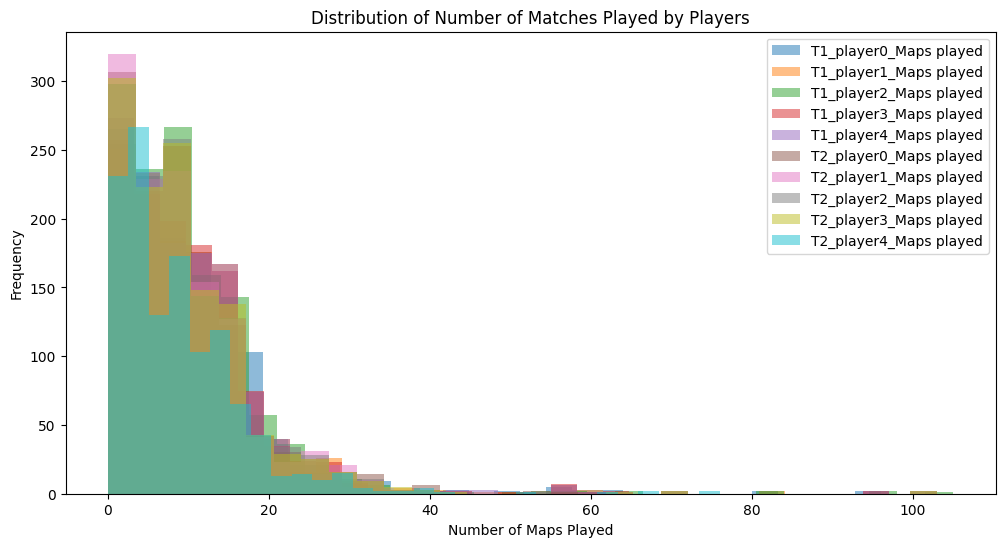

In [8]:
maps_played_columns = [col for col in cleaned_data.columns if 'Maps played' in col]

# Plot the distributions
plt.figure(figsize=(12, 6))
for col in maps_played_columns:
    plt.hist(cleaned_data[col], bins=30, alpha=0.5, label=col)

# Adding labels and title
plt.xlabel('Number of Maps Played')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Matches Played by Players')
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [12]:
# Step 1: Identify columns related to K/D Ratio and Total kills for both teams
kd_ratio_columns = [col for col in cleaned_data.columns if 'K/D Ratio' in col]
total_kills_columns = [col for col in cleaned_data.columns if 'Total kills' in col]

# Step 2: Replace '∞' in K/D Ratio with the corresponding Total kills for each player
for kd_col, kills_col in zip(kd_ratio_columns, total_kills_columns):
    # Replace '∞' in K/D Ratio with the player's Total kills
    cleaned_data[kd_col] = cleaned_data.apply(
        lambda row: row[kills_col] if row[kd_col] == '∞' else row[kd_col], axis=1
    )

# Verify if the infinite values have been replaced
print(cleaned_data[kd_ratio_columns].head())

  T1_player0_K/D Ratio  T1_player1_K/D Ratio  T1_player2_K/D Ratio  \
0                 1.37                  1.00                  1.05   
1                 0.91                  1.02                  1.17   
2                  0.9                  0.84                  1.09   
3                 0.76                  1.02                  0.61   
4                  0.8                  0.85                  1.12   

   T1_player3_K/D Ratio  T1_player4_K/D Ratio  T2_player0_K/D Ratio  \
0                  1.13                  0.89                  0.97   
1                  0.88                  1.02                  1.25   
2                  1.01                  1.05                  0.89   
3                  0.85                  0.80                  0.87   
4                  0.97                  1.09                  1.40   

   T2_player1_K/D Ratio  T2_player2_K/D Ratio  T2_player3_K/D Ratio  \
0                  1.15                  0.56                  0.83   
1         

In [13]:
# Step 1: Filter out rows with missing values
cleaned_data_no_missing = cleaned_data.dropna()

# Step 2: Calculate the correlation for each column with 'team1_win'
correlation_with_win = cleaned_data_no_missing.corr()['team1_win']

# Step 3: Calculate the absolute correlation values
absolute_correlation_with_win = correlation_with_win.abs()

# Step 4: Define player statistics to aggregate by attribute (e.g., Total kills, K/D Ratio, etc.)
attributes = [
    'Total kills', 'Headshot %', 'Total deaths', 'K/D Ratio', 'Damage / Round', 'Grenade dmg / Round',
    'Maps played', 'Rounds played', 'Kills / round', 'Assists / round', 'Deaths / round',
    'Saved by teammate / round', 'Saved teammates / round', 'Rating 2.0'
]

# Step 5: Group columns by attributes and calculate the aggregated average absolute correlation for each attribute
aggregated_correlations = {}

for attribute in attributes:
    # Get all columns that correspond to this attribute
    matching_columns = [col for col in absolute_correlation_with_win.index if attribute in col]
    # Calculate the mean of absolute correlations for this attribute
    aggregated_correlations[attribute] = absolute_correlation_with_win[matching_columns].mean()

# Convert the aggregated correlations to a DataFrame for easy viewing
aggregated_correlations_df = pd.DataFrame.from_dict(aggregated_correlations, orient='index', columns=['Absolute Correlation'])

# Sort the results by correlation strength
aggregated_correlations_df_sorted = aggregated_correlations_df.sort_values(by='Absolute Correlation', ascending=False)

# Display the sorted aggregated correlations
print(aggregated_correlations_df_sorted)


                           Absolute Correlation
Deaths / round                         0.253496
Rating 2.0                             0.238209
K/D Ratio                              0.219287
Kills / round                          0.164163
Damage / Round                         0.138380
Assists / round                        0.084660
Grenade dmg / Round                    0.065818
Total kills                            0.047599
Maps played                            0.046887
Rounds played                          0.046189
Total deaths                           0.045644
Saved by teammate / round              0.039383
Saved teammates / round                0.030068
Headshot %                             0.023708
